In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Creating the Data

In [ ]:
data_size = 1000

X = torch.arange(-5, 5, step=(10/data_size), device=device)
y = 2*(X**3) - 3*(X**2) + 3*X + 500
noise = 10*torch.randn((data_size,), device=device)
y = y + noise


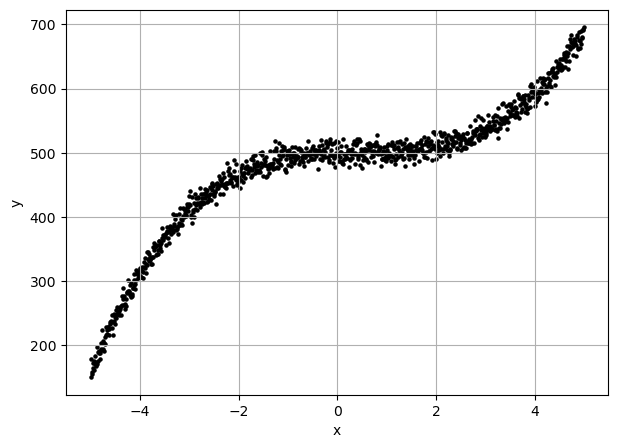

In [54]:
plt.figure(figsize=(7,5))
plt.scatter(x = X.cpu(), y = y.cpu(), marker='o', color = 'black', s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

## Manual Training Loop

In [55]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)

c = a + b**2
e = c*b

e.backward()
b.grad

tensor(77.)

In [56]:
W = torch.tensor([0.,0.,0.,0.,], requires_grad=True)

def init(W):
    if (W.grad != None):
        W.grad.zero_() 
    with torch.no_grad():
        W.zero_()

def f(X, W):
    return W[0]*(X**3) + W[1]*(X**2) + W[2]*X + W[3]
    
def err(W, X, y):
    y_pred = f(X, W)
    return torch.mean((y_pred - y)**2)

def update_step(W, X, Y, eps, beta, di):
    e = err(W, X, Y)
    e.backward()
    with torch.no_grad():
        W.sub_(eps * W.grad + beta * di)
        di.copy_(W.grad.detach())
        W.grad.zero_()
    
    return e.detach().item()

def report(i, e):
    print(f"[{i}] a={W[0]:.2f} b={W[1]:.2f}, c={W[2]:.2f}, d={W[3]:.2f} err={e[i]:.2f}")

In [57]:
N = 20000
ers = np.zeros(N)
init(W)
grad_prev = torch.tensor([0.,0.,0.,0.])
for i in range(N):
    ers[i] = update_step(W, X, y, 0.00045, 0.00022, di=grad_prev)
    if (i % 1000) == 0:
        report(i, ers)
report(N-1,ers)

[0] a=4.31 b=3.41, c=0.25, d=0.43 err=237062.33
[1000] a=2.06 b=15.41, c=2.05, d=225.26 err=33860.25
[2000] a=2.04 b=7.17, c=2.51, d=348.49 err=10411.02
[3000] a=2.02 b=2.61, c=2.65, d=416.59 err=3251.65
[4000] a=2.02 b=0.09, c=2.72, d=454.21 err=1065.72
[5000] a=2.02 b=-1.30, c=2.75, d=475.00 err=398.32
[6000] a=2.02 b=-2.07, c=2.77, d=486.49 err=194.55
[7000] a=2.01 b=-2.49, c=2.78, d=492.84 err=132.34
[8000] a=2.01 b=-2.72, c=2.78, d=496.35 err=113.34
[9000] a=2.01 b=-2.85, c=2.79, d=498.29 err=107.54
[10000] a=2.01 b=-2.93, c=2.79, d=499.36 err=105.77
[11000] a=2.01 b=-2.97, c=2.79, d=499.95 err=105.23
[12000] a=2.01 b=-2.99, c=2.79, d=500.27 err=105.06
[13000] a=2.01 b=-3.00, c=2.79, d=500.46 err=105.01
[14000] a=2.01 b=-3.01, c=2.79, d=500.56 err=105.00
[15000] a=2.01 b=-3.01, c=2.79, d=500.61 err=104.99
[16000] a=2.01 b=-3.01, c=2.79, d=500.64 err=104.99
[17000] a=2.01 b=-3.01, c=2.79, d=500.65 err=104.99
[18000] a=2.01 b=-3.01, c=2.79, d=500.65 err=104.99
[19000] a=2.01 b=-3.01

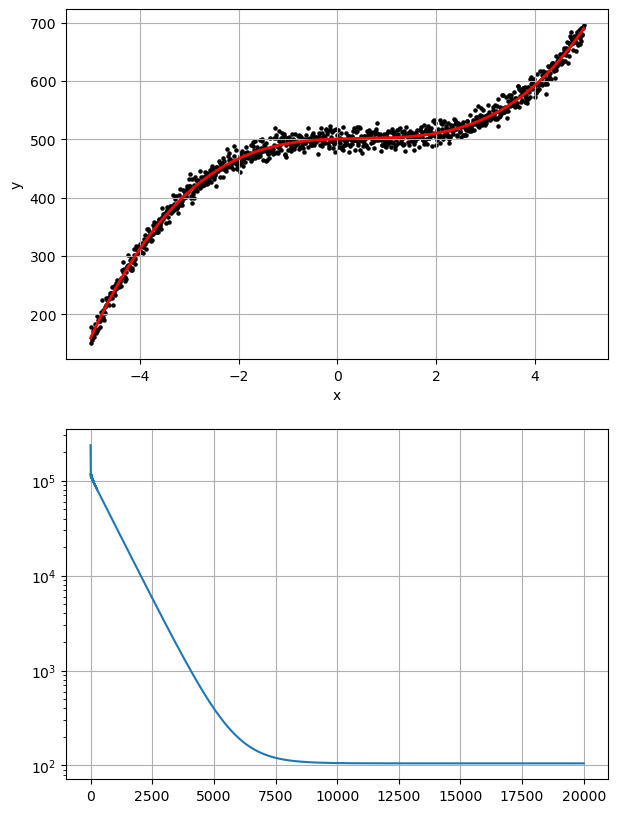

In [58]:
with torch.no_grad():
    y_pred = f(X, W)

plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.scatter(x = X.cpu(), y = y.cpu(), marker='o', color = 'black', s=5)
plt.plot(X.cpu(), y_pred.cpu(), color='red', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ers)
plt.yscale('log')
plt.grid(True)

plt.show()


## Pytorch API

In [90]:
class PolyFit(torch.nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.degree = degree + 1
        self.W = torch.nn.Parameter(torch.zeros(self.degree, device=device))
    
    def forward(self, x):
        y = torch.zeros_like(x, device=device)
        for i in range(self.degree):
            y += self.W[i] * (x**i)
        return y

def train(model, x, y_true, lossFn, optimizerFn, lr, epochs):
    loss = lossFn()
    optimizer = optimizerFn(model.parameters(), lr=lr)
    for i in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred , y_true)
        l.backward()
        optimizer.step()
        if (i % 1000) == 0:
            with torch.no_grad():
                print(f"({i}): err={l}, params={next(model.parameters()).cpu().numpy()}")

In [148]:
poly = PolyFit(3)

train(poly, X, y, torch.nn.MSELoss, torch.optim.SGD, 0.00044, 20000)

(0): err=237062.328125, params=[0.41825905 0.24010122 3.3342383  4.215722  ]
(1000): err=50821.578125, params=[163.00922     1.6900759  19.577688    2.088078 ]
(2000): err=23379.3203125, params=[271.93057     2.2612705  12.290172    2.0519722]
(3000): err=10785.818359375, params=[345.71783     2.4990168   7.3534026   2.035873 ]
(4000): err=5006.56982421875, params=[395.70325     2.6137776   4.009126    2.0275607]
(5000): err=2354.386962890625, params=[429.5651      2.6771612   1.7436036   2.0227346]
(6000): err=1137.256591796875, params=[4.5250439e+02 2.7156432e+00 2.0885433e-01 2.0197153e+00]
(7000): err=578.7154541015625, params=[468.0438      2.740329   -0.8308042   2.0177472]
(8000): err=322.3891296386719, params=[478.5708      2.7566206  -1.5351121   2.016438 ]
(9000): err=204.75552368164062, params=[485.7023      2.7675285  -2.0122445   2.0155585]
(10000): err=150.7738494873047, params=[490.53326     2.7748733  -2.335456    2.0149646]
(11000): err=126.00228881835938, params=[493.

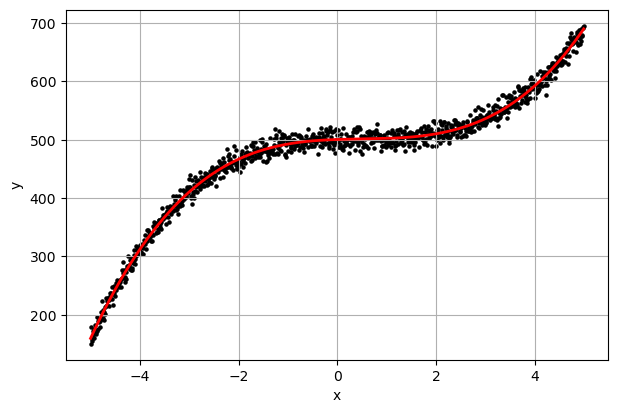

In [149]:
with torch.no_grad():
    y_pred = poly(X)
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.scatter(x = X.cpu(), y = y.cpu(), marker='o', color = 'black', s=5)
plt.plot(X.cpu(), y_pred.cpu(), color='red', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)